In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots

import shap
from pathlib import Path
from modelling_pipeline import features
from joblib import dump, load
import matplotlib as mpl

plt.rcParams['figure.dpi'] = 150
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['font.family'] = 'Optima'
mpl.rcParams['text.usetex'] = 'False'

/Users/thor/dev/data-science/gender-pay-gap-modelling/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/thor/dev/data-science/gender-pay-gap-modelling/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
def correlatePredictions(model, val_X, val_y, name):
    preds = model.predict(val_X)
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(preds, val_y, cmap=plt.cm.Spectral, s=7, edgecolor='k', lw=1)

    ax.set_xlabel('Predicted pay gap (%)',  **{ 'fontsize': 18})
    ax.set_ylabel('Actual pay gap (%)',  **{ 'fontsize': 18})
    ax.set_title(name,  **{ 'fontsize': 24})
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=False, labelsize=14)
    plt.tick_params(axis='x', which='both', labelleft=True, labelright=False, labelsize=14)
    plt.tight_layout()
    plt.savefig('viz/{}-correlation.png'.format(name), dpi=150)
    plt.show()



def feature_importance(model, X, target_name):
    feature_importances = pd.DataFrame(
        model.feature_importances_,
        index=X.columns,
        columns=['importance']).sort_values('importance', ascending=False)[:10]
    fig, ax = plt.subplots(figsize=(7, 10))
    sns.barplot(ax=ax, data=feature_importances.reset_index(), 
                x='importance', 
                y='index', orient='h', palette="Blues_d")
    ax.set_xlabel('Importance',  **{ 'fontsize': 16})
    ax.set_ylabel('Feature',  **{ 'fontsize': 16})
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=False, labelsize=12)
    plt.tick_params(axis='x', which='both', labelleft=True, labelright=False, labelsize=12)
    plt.tight_layout()
    plt.savefig('viz/{}-fi.png'.format(target_name), dpi=150)
    plt.show()


def permutation_importance(model, X, y, target_name):
    perm = PermutationImportance(model, random_state=1).fit(X, y)
    eli5.show_weights(perm, feature_names=X.columns.tolist())
    plt.tight_layout()
    plt.savefig('viz/{}-perm-imp.png'.format(target_name), dpi=150)
    plt.show()


def partial_dependence_plot(model, data, feature_names, feature_to_plot, target_name):
    pdp_score = pdp.pdp_isolate(model=model, dataset=data, model_features=feature_names,
                                feature=feature_to_plot)
    pdp.pdp_plot(pdp_score, feature_to_plot, plot_params= {
        # plot title and subtitle
        'title': 'PDP for feature "%s"' % feature_to_plot,
        'subtitle': "Number of unique grid points: %d" % 10,
        'title_fontsize': 32,
        'subtitle_fontsize': 24,
        'font_family': 'Optima',
        # matplotlib color map for ICE lines
        'line_cmap': 'Spectral',
        'xticks_rotation': 0,
        'xticks_fontsize': 32,
        'yticks_fontsize': 32,
        
        # pdp line color, highlight color and line width
        'pdp_color': '#3287bc',
        'pdp_hl_color': '#FEDC00',
        'pdp_linewidth': 4,
        # horizon zero line color and with
        'zero_color': '#E75438',
        'zero_linewidth': 1,
        # pdp std fill color and alpha
        'fill_color': '#3287bc',
        'fill_alpha': 0.2,
        # marker size for pdp line
        'markersize': 10,
    })
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=False, labelsize=32)
    plt.tick_params(axis='x', which='both', labelleft=True, labelright=False, labelsize=32)
    plt.xlabel('')
    plt.tight_layout()
    pdp.plt.savefig('viz/{}-{}-pdp.png'.format(target_name, feature_to_plot), dpi=150)
    plt.show()


def plot_shap_values(model, X, target_name):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    # calculate shap values. This is what we will plot.
    # Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X,show=False)
    # Change the colormap of the artists
    for fc in plt.gcf().get_children():
        for fcc in fc.get_children():
            if hasattr(fcc, "set_cmap"):
                fcc.set_cmap(plt.cm.Spectral)
    plt.savefig('viz/{}-shap.png'.format(target_name), dpi=150)


def explain_model(target_name, X, y):
    model = load('models/{}-best-model.joblib'.format(target_name))
    correlatePredictions(model, X, y, target_name)
    partial_dependence_plot(model, X.sample(frac=0.5), features, 'RepresentationInLowerQuartileSkew' , target_name )
    partial_dependence_plot(model, X.sample(frac=0.5), features, 'RepresentationInTopQuartileSkew' , target_name )
    #plot_shap_values(model, X.sample(frac=0.1), target_name)
    # permutation_importance(model, X, y, target_name)
    #feature_importance(model, X, target_name)




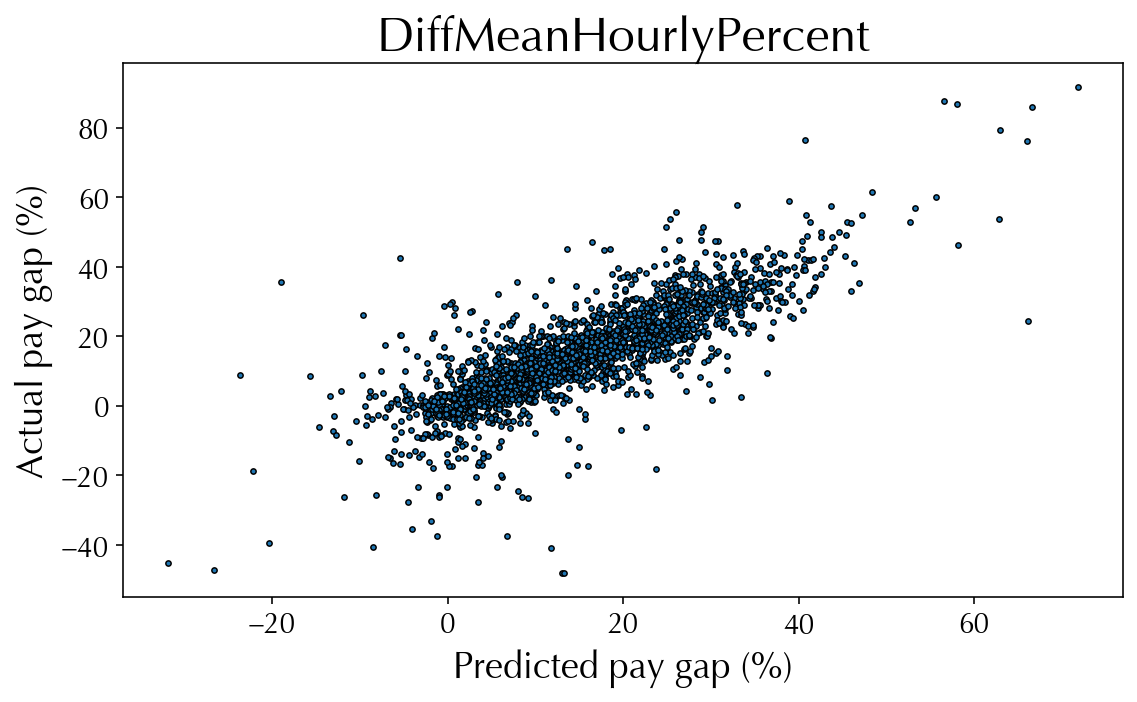

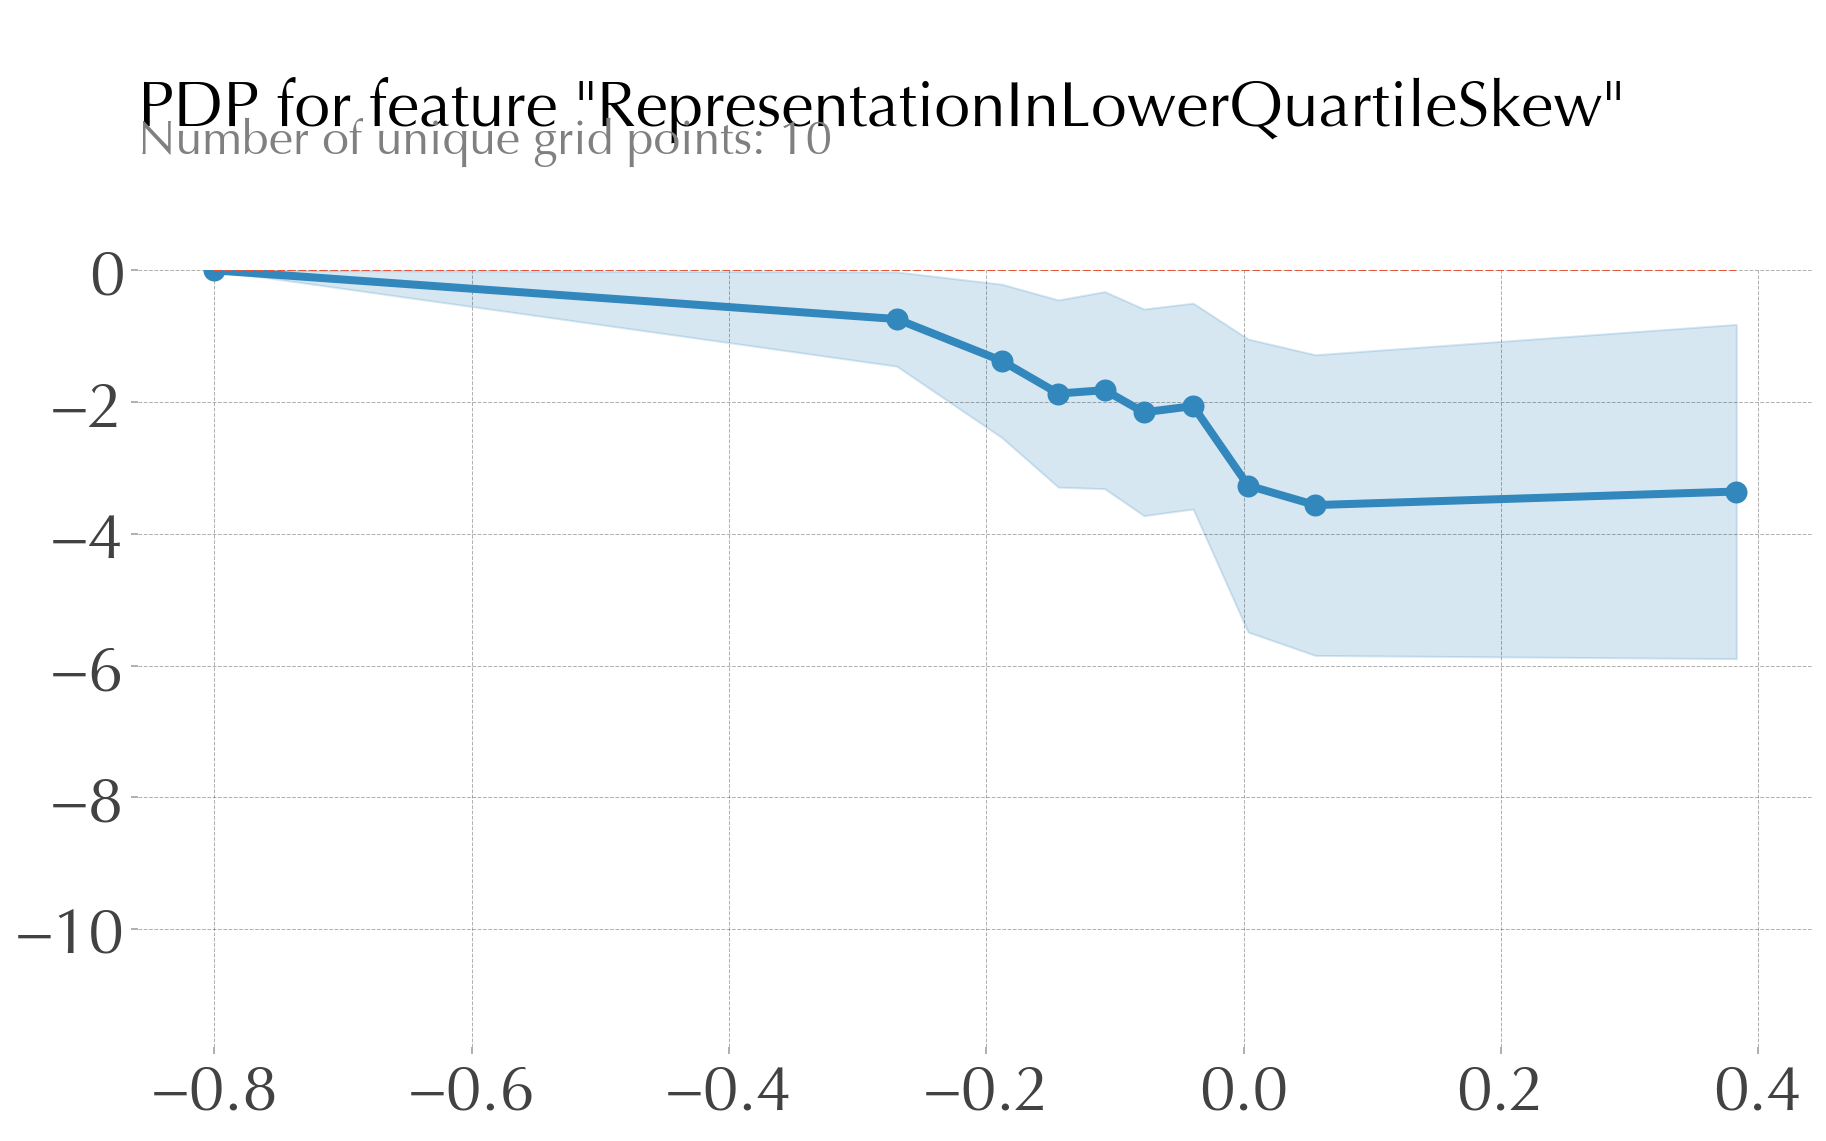

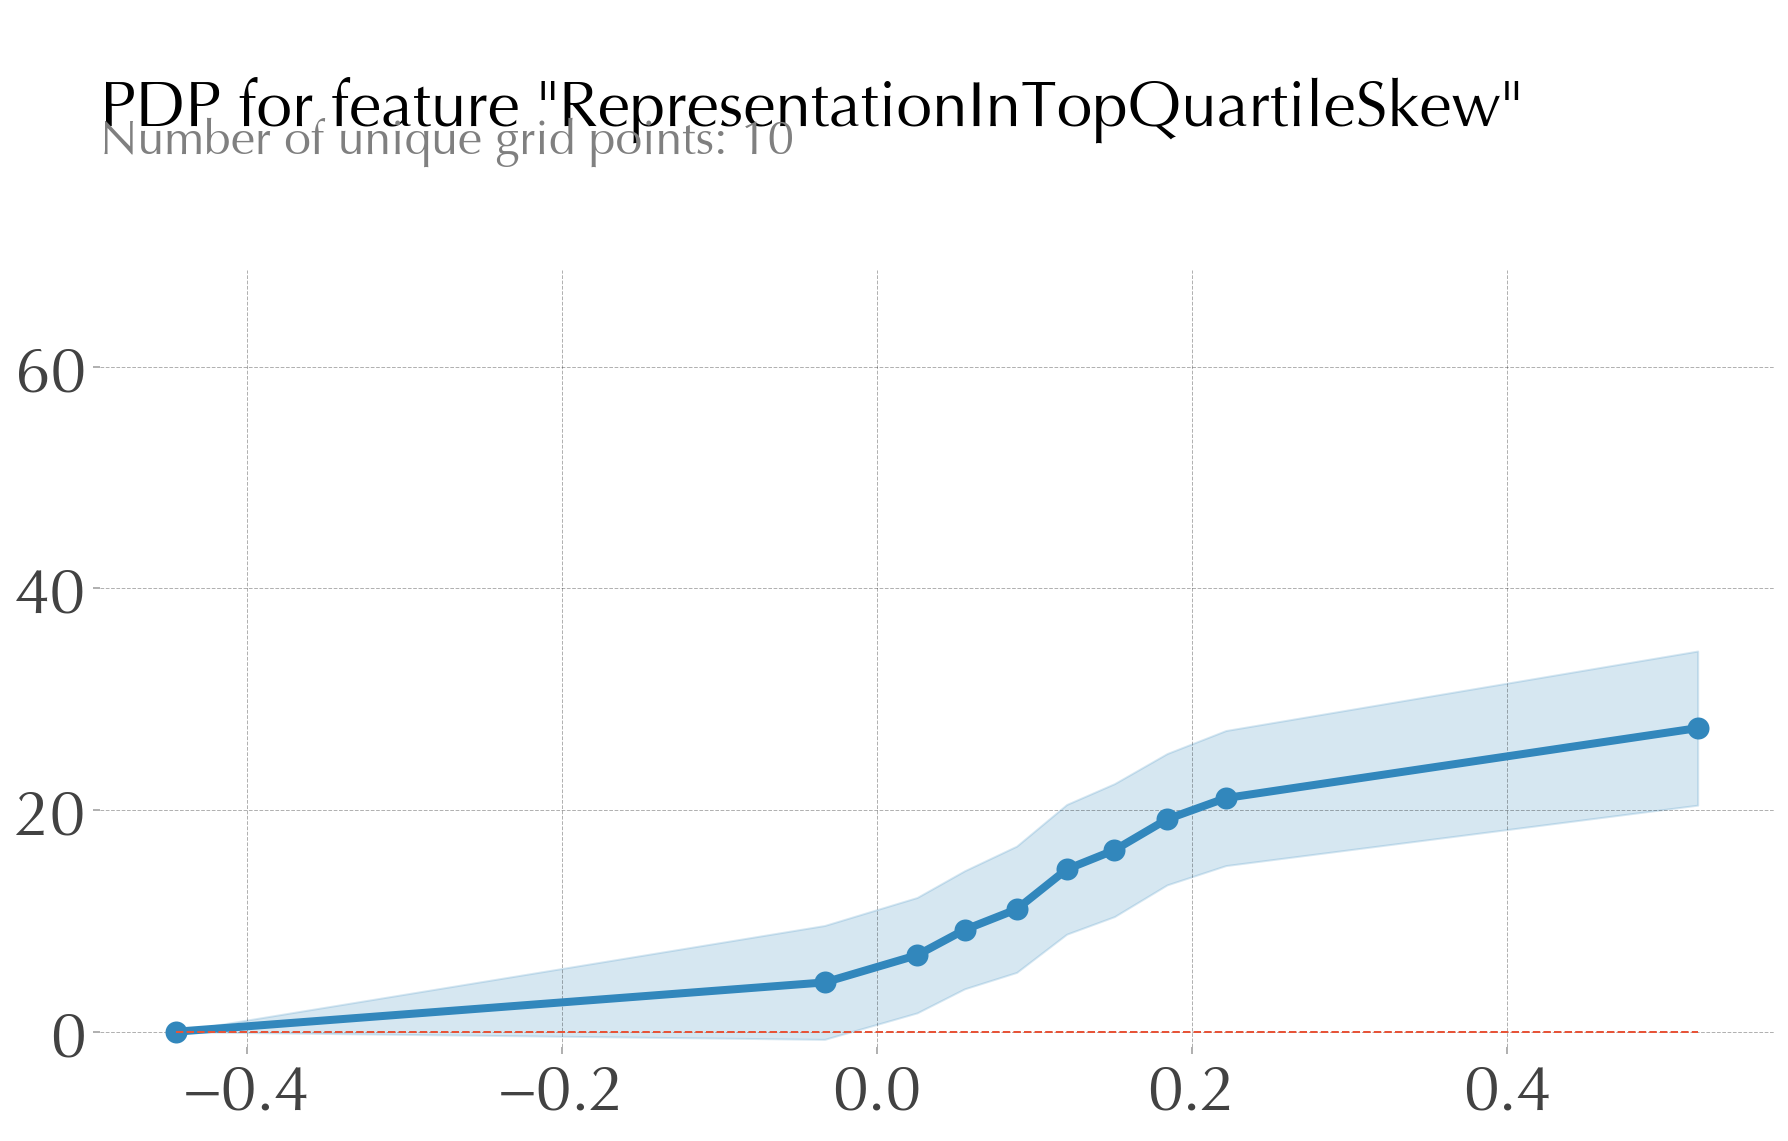

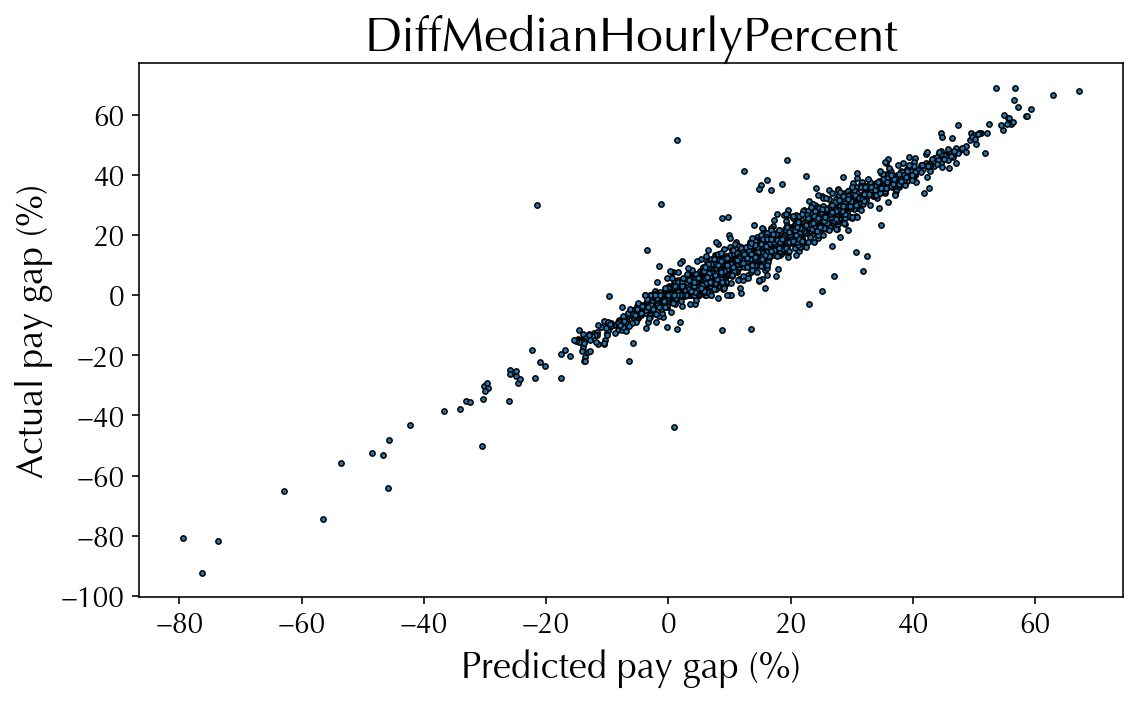

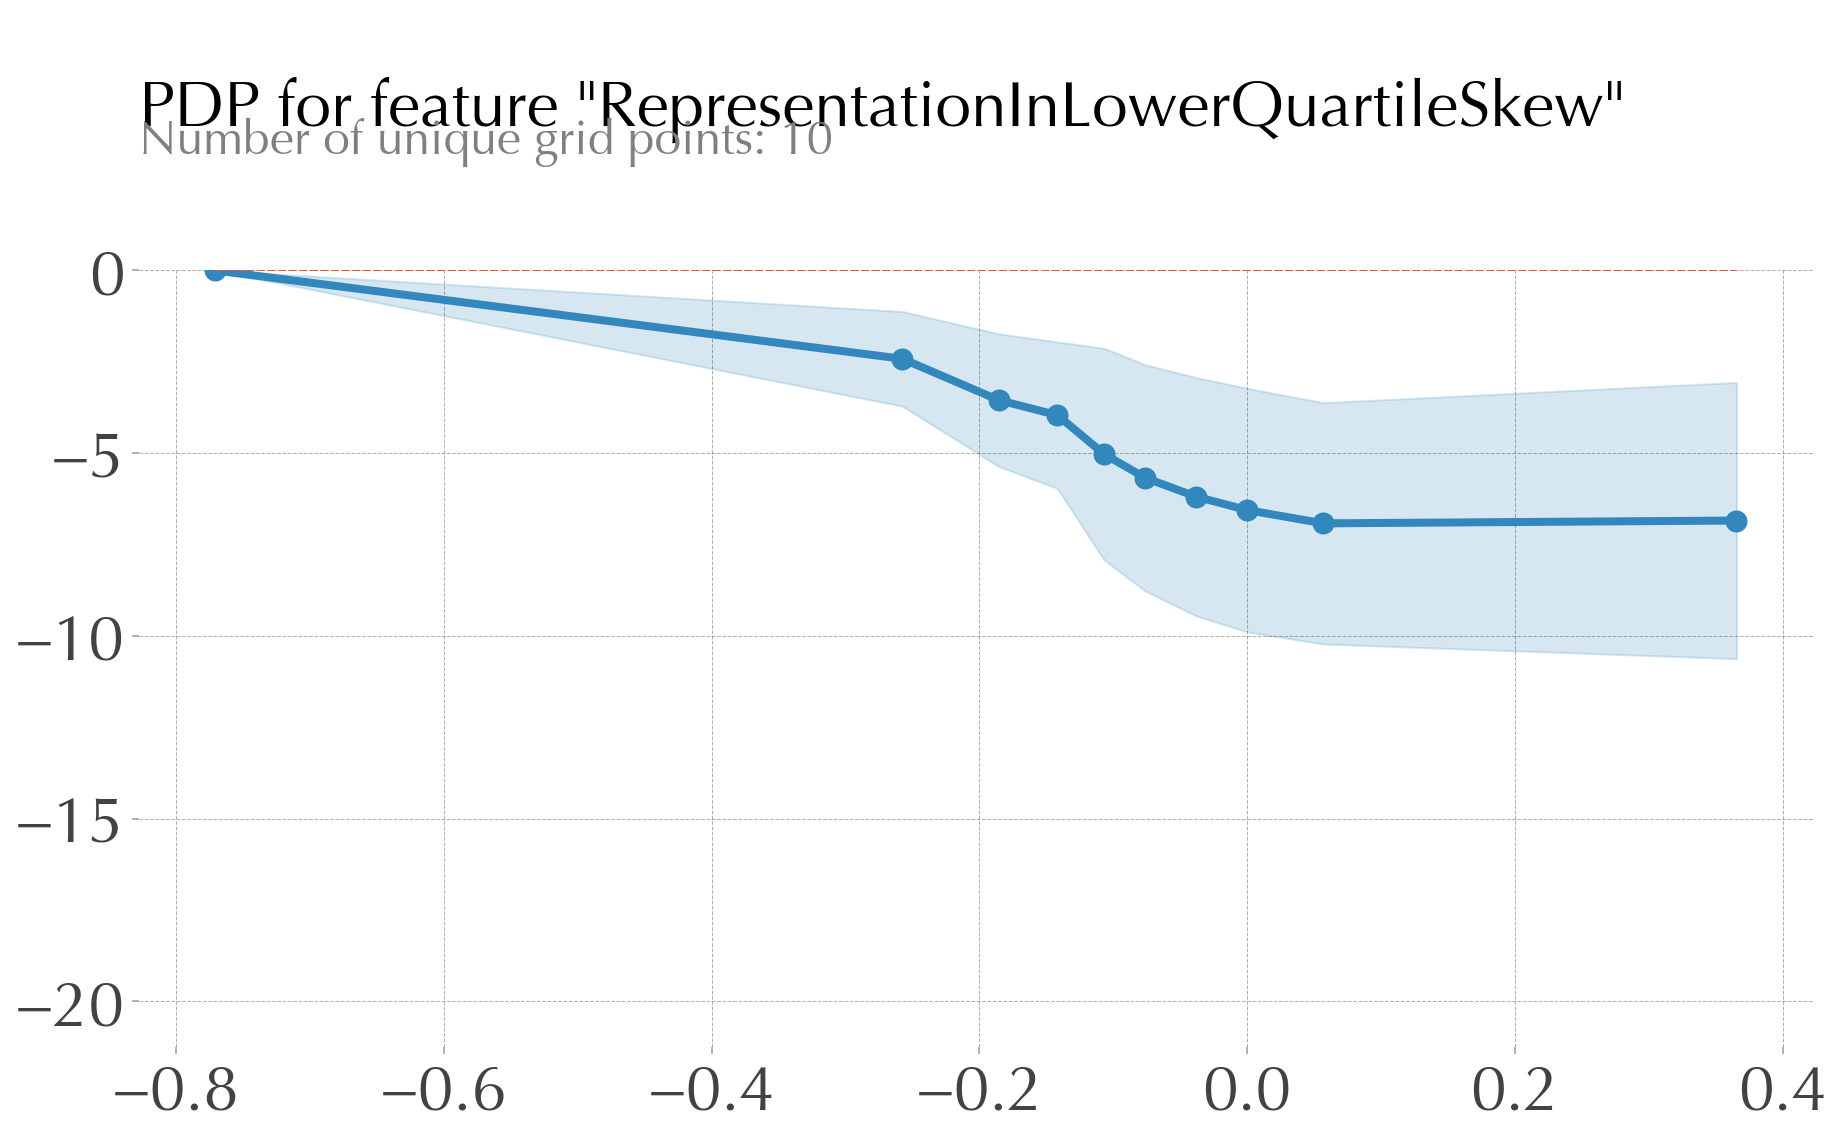

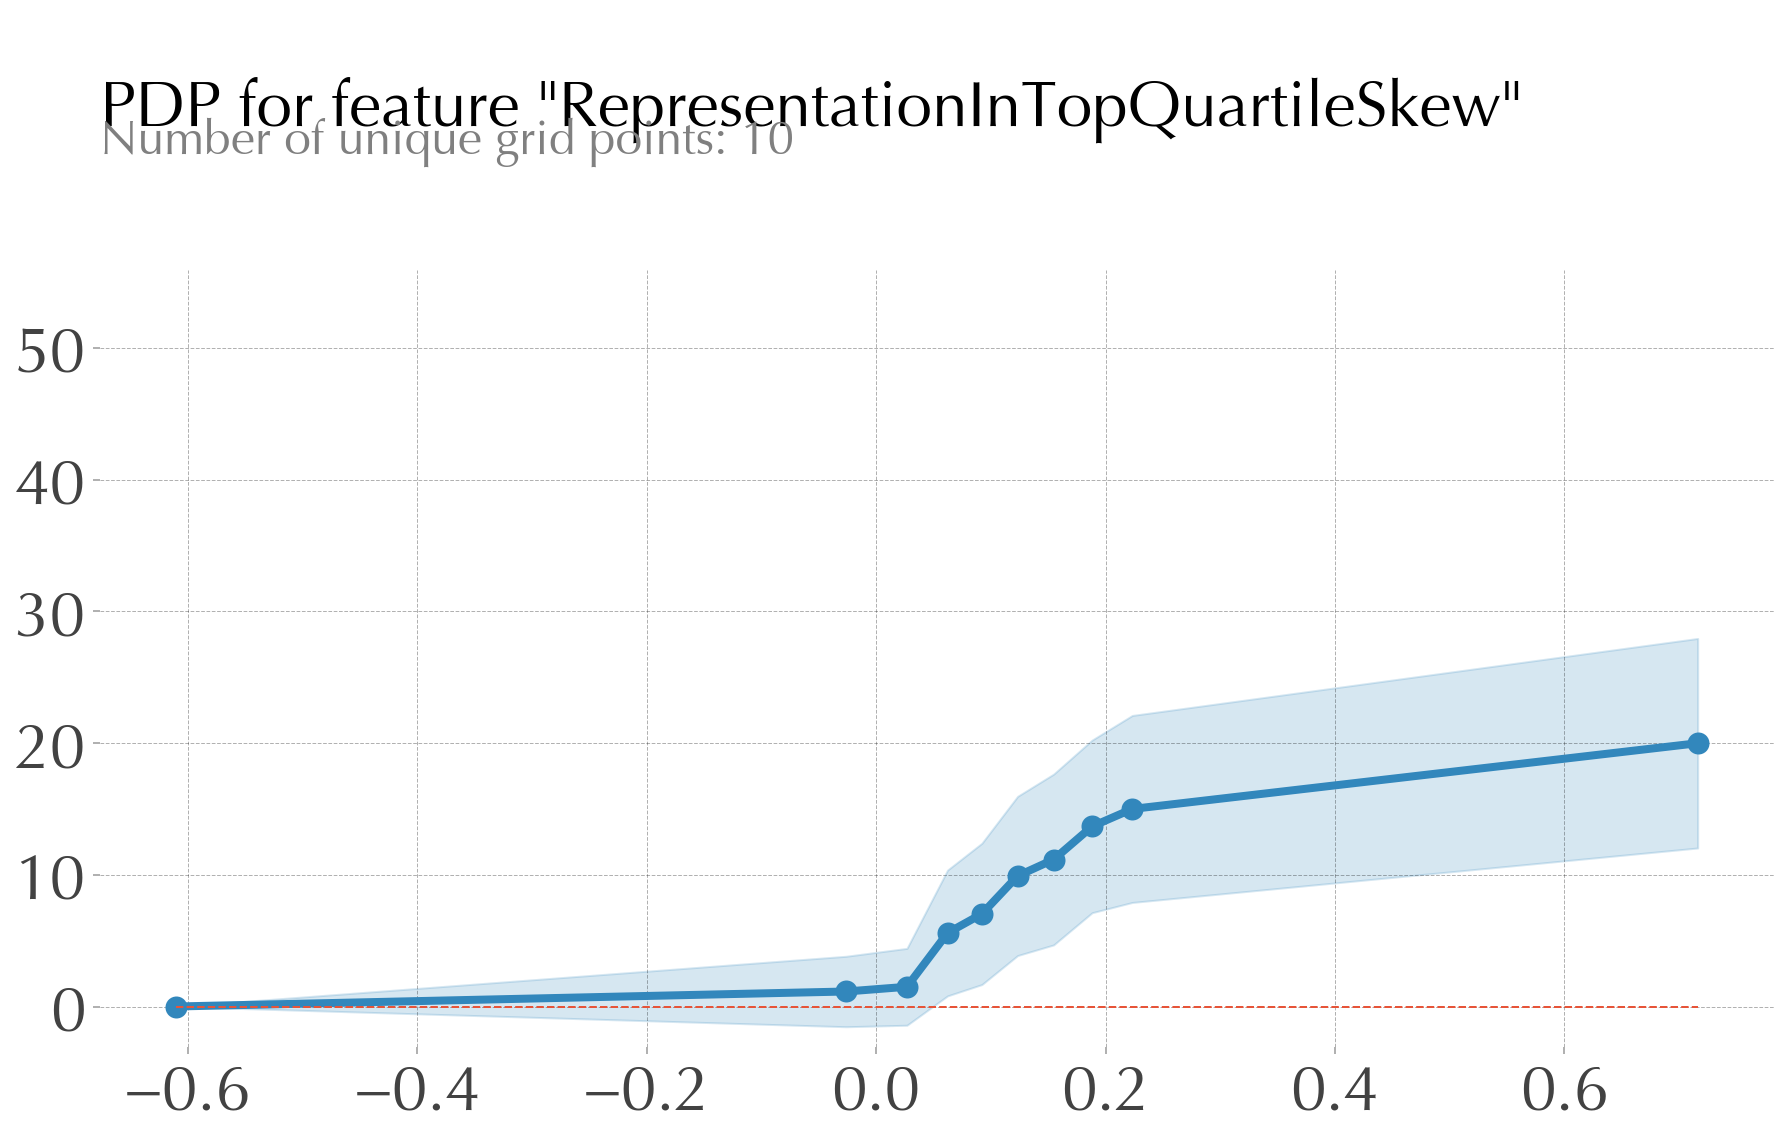

In [14]:
Path('viz').mkdir(parents=True, exist_ok=True)
df = pd.read_csv('data/holdout_data.csv')
X = df[features]
for target in ['DiffMeanHourlyPercent', 'DiffMedianHourlyPercent']:
    y = df[target].values
    explain_model(target, X, y)



#

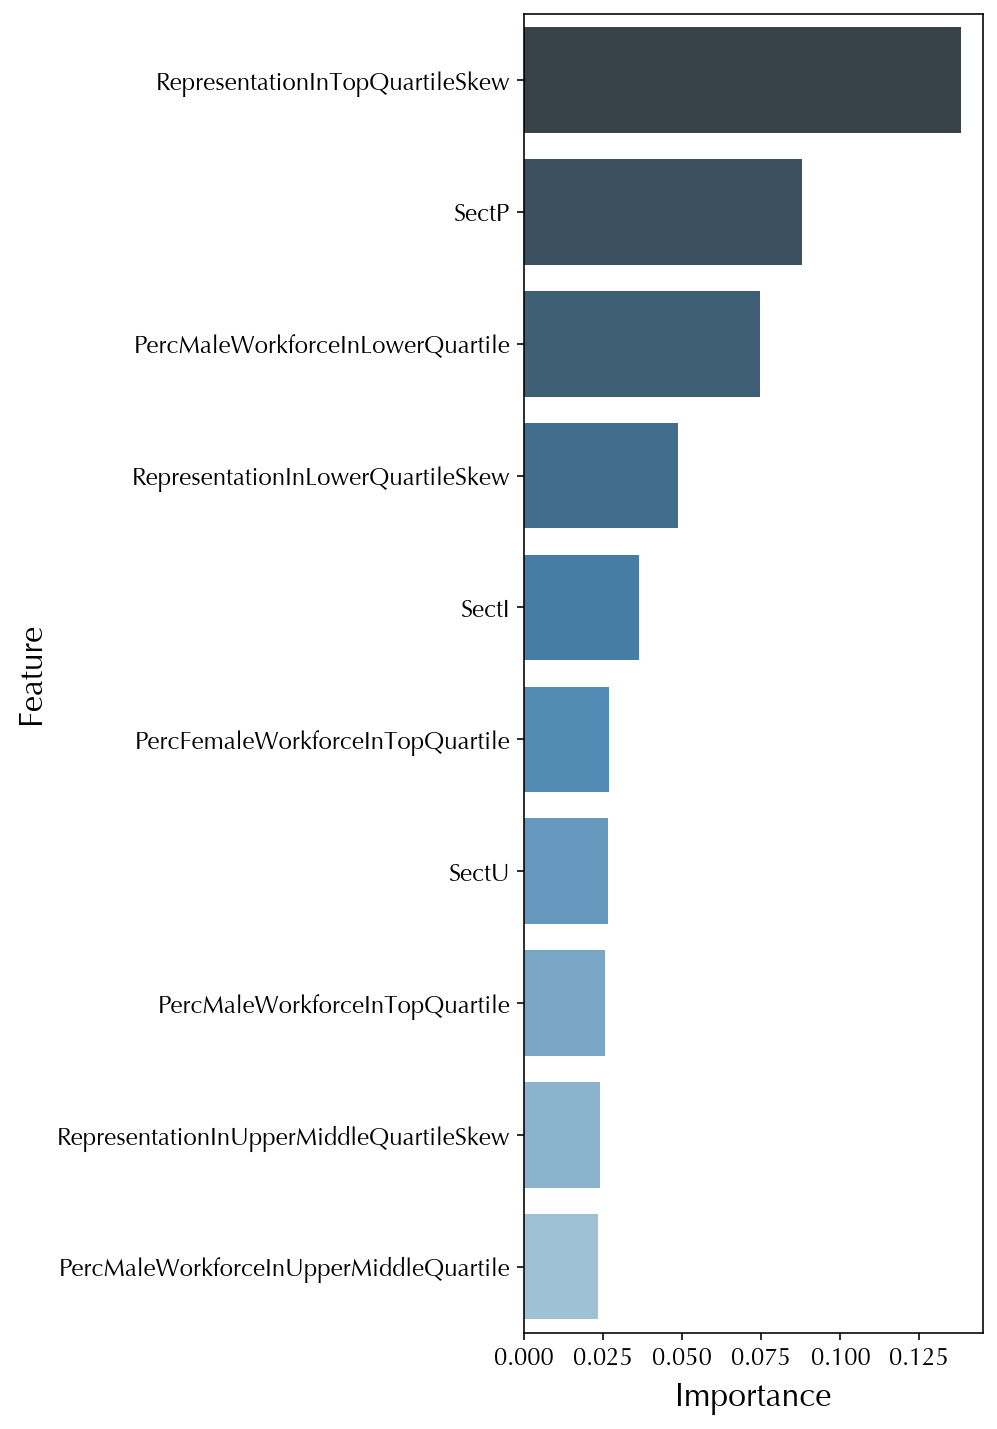

<Figure size 432x288 with 0 Axes>

In [6]:
target_name='DiffMedianHourlyPercent'
model = load('models/{}-best-model.joblib'.format(target_name))
feature_importance(model, X, target_name)
plt.tight_layout()


In [37]:
df_model_scores = pd.read_csv('data/averaged_model_scores.csv')

for target in ['DiffMeanHourlyPercent', 'DiffMedianHourlyPercent']:
    tmp = df_model_scores[df_model_scores.prediction==target]
    print(target)
    for num, data in tmp.iterrows():
        print("& {} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
            data['modelName'],
            data['MeanAveErr'],
            data['RootMeanSqErr'],
            data['r2']
        ))


DiffMeanHourlyPercent
& adaboost & 9.33 & 13.16 & 0.21 \\
& decision_tree & 6.57 & 12.49 & 0.28 \\
& extra_trees & 5.30 & 9.32 & 0.61 \\
& extra_trees2 & 5.39 & 9.27 & 0.61 \\
& gradboost & 5.79 & 9.80 & 0.57 \\
& linear_reg & 6.31 & 10.41 & 0.51 \\
& random_forest & 5.55 & 9.48 & 0.60 \\
& svm & 6.00 & 10.27 & 0.53 \\
& xgboost & 5.25 & 9.22 & 0.62 \\
DiffMedianHourlyPercent
& adaboost & 8.71 & 12.16 & 0.40 \\
& decision_tree & 6.93 & 11.32 & 0.48 \\
& extra_trees & 5.46 & 8.89 & 0.68 \\
& extra_trees2 & 5.55 & 8.94 & 0.68 \\
& gradboost & 6.06 & 9.55 & 0.63 \\
& linear_reg & 6.55 & 9.93 & 0.60 \\
& random_forest & 5.72 & 9.19 & 0.66 \\
& svm & 6.31 & 10.16 & 0.58 \\
& xgboost & 5.41 & 8.87 & 0.68 \\


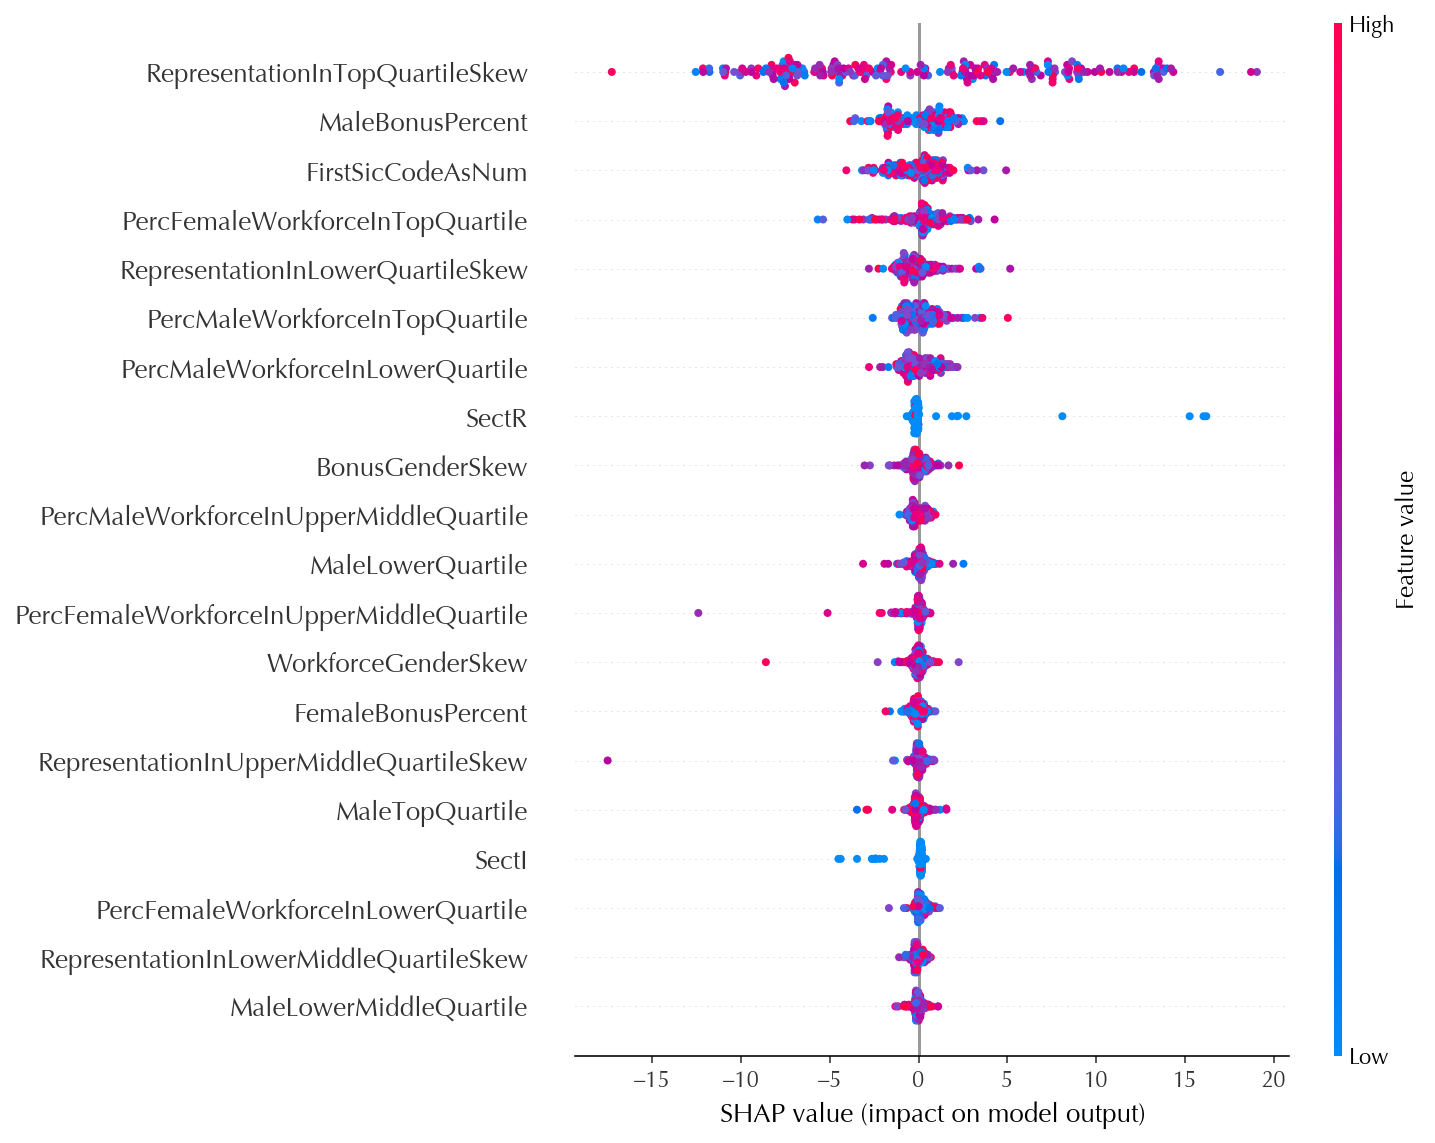

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [45]:
target_name='DiffMeanHourlyPercent'

plot_shap_values(model, X.sample(frac=1), target_name)
plt.tight_layout()
plt.savefig('viz/{}-shap.png'.format(target_name), dpi=150)
